<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (9 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize


%matplotlib inline

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

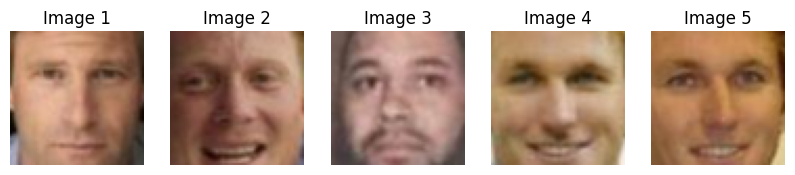

In [ ]:
import torch
from sklearn.model_selection import train_test_split

train_data, val_data, train_attrs, val_attrs = train_test_split(data, attrs, test_size=0.1, shuffle=False)

# Выводим несколько картинок из train_data
num_images_to_display = 5

plt.figure(figsize=(10, 5))
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(train_data[i])
    plt.title(f"Image {i+1}")
    plt.axis('off')

plt.show()

train_data_tensor = torch.tensor(train_data).permute(0, 3, 1, 2)
val_data_tensor = torch.tensor(val_data).permute(0, 3, 1, 2)

train_loader = torch.utils.data.DataLoader(train_data_tensor, batch_size=64)
val_loader = torch.utils.data.DataLoader(val_data_tensor, batch_size=64)

In [ ]:
print(train_data_tensor[0].shape)

torch.Size([3, 64, 64])


## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 32 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # Input: 64x64x3, Output: 32x32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Input: 32x32x32, Output: 16x16x64
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Input: 16x16x64, Output: 8x8x128
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # Input: 8x8x128, Output: 4x4x256
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Input: 4x4x256, Output: 8x8x128
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Input: 8x8x128, Output: 16x16x64
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Input: 16x16x64, Output: 32x32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # Input: 32x32x32, Output: 64x64x3
            nn.Sigmoid(),  # Восстанавливаем значения пикселей в диапазоне [0, 1]
        )

    def forward(self, x):
        # Encoder
        latent_code = self.encoder(x)

        # Decoder
        reconstruction = self.decoder(latent_code)

        return reconstruction, latent_code

In [ ]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion = F.mse_loss

autoencoder = Autoencoder().to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:

# Обучение автоэнкодера
n_epochs = 50
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        reconstruction, _ = autoencoder(batch.to(device).float())  # Преобразуем входные данные в тип float32
        loss = criterion(reconstruction, batch.to(device).float().view(-1, 3, 64, 64))  # Преобразуем размер пакета
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_loss = np.mean(train_losses_per_epoch)
    train_losses.append(train_loss)

    # Выводим реконструкции для нескольких изображений из val выборки
    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in val_loader:
            reconstruction, _ = autoencoder(batch.to(device).float())  # Преобразуем входные данные в тип float32
            loss = criterion(reconstruction, batch.to(device).float().view(-1, 3, 64, 64))  # Преобразуем размер пакета
            val_losses_per_epoch.append(loss.item())

        val_loss = np.mean(val_losses_per_epoch)
        val_losses.append(val_loss)

        # Выводим реконструкции для нескольких изображений из val выборки
        if (epoch + 1) % 1 == 0:
            num_images_to_display = 5
            plt.figure(figsize=(12, 6))
            for i in range(num_images_to_display):
                plt.subplot(2, num_images_to_display, i + 1)
                plt.imshow(batch[i].cpu().permute(1, 2, 0))
                plt.title("Original")
                plt.axis('off')

                plt.subplot(2, num_images_to_display, i + num_images_to_display + 1)
                plt.imshow(reconstruction[i].cpu().permute(1, 2, 0))
                plt.title("Reconstructed")
                plt.axis('off')
            plt.show()

    print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Выводим графики потерь на train и val выборках
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

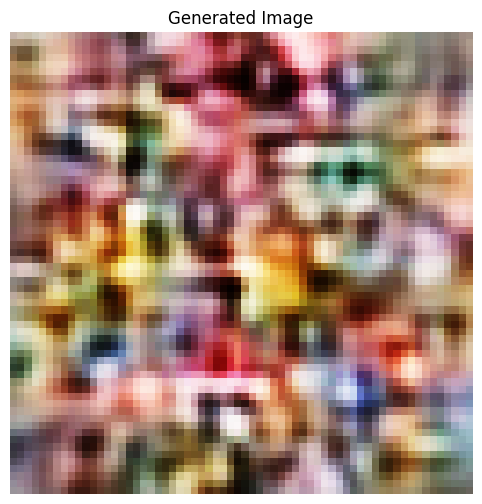

In [ ]:

# Генерируем случайные латентные векторы для создания новых изображений
latent_space_dim = 256
num_images_to_generate = 1
random_latent_vectors = torch.randn(1, 256, 4, 4).to(device)

# Подаем случайные латентные векторы на вход декодеру
autoencoder.eval()  # Переводим модель в режим оценки (evaluation) для отключения dropout и batch normalization
with torch.no_grad():
    generated_images = autoencoder.decoder(random_latent_vectors)

# Выводим созданные изображения
plt.figure(figsize=(12, 6))
for i in range(num_images_to_generate):
    plt.subplot(1, num_images_to_generate, i + 1)
    plt.imshow(generated_images[i].cpu().permute(1, 2, 0))
    plt.title("Generated Image")
    plt.axis('off')
plt.show()

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
train_attrs['Smiling'] = train_attrs['Smiling'].astype('double')
train_smiles = train_attrs['Smiling']

threshold     = 0  # Пороговое значение, которое вы можете настроить
smile_indices = train_smiles >= threshold  # Отбор улыбающихся
frown_indices = train_smiles < threshold   # Отбор грустных

# Отдельно выберите изображения и атрибуты улыбающихся и грустных лиц
smile_images = train_data_tensor[smile_indices].float().to(device)
frown_images = train_data_tensor[frown_indices].float().to(device)

with torch.no_grad():
    smile_latent_vectors = autoencoder.encoder(smile_images)
    frown_latent_vectors = autoencoder.encoder(frown_images)

mean_smile_latent_vector = torch.mean(smile_latent_vectors, dim=0)
mean_frown_latent_vector = torch.mean(frown_latent_vectors, dim=0)

# Вычислите вектор улыбки (разность между средними латентными векторами улыбающихся и грустных людей)
smile_vector = mean_smile_latent_vector - mean_frown_latent_vector

sad_people = train_data[frown_indices]
plt.figure(figsize=(12, 6))
plt.imshow(train_data[11571])
plt.axis('off')
plt.show()




In [ ]:
train_smiles.idxmin()

In [ ]:
with torch.no_grad():
    frown_latent = autoencoder.encoder(train_data_tensor[11571].float().to(device))
    # Прогоните латентный вектор грустного человека через decoder с добавлением вектора улыбки
    smile_added_latent_vector = frown_latent + smile_vector
    # Прогоните полученный латентный вектор через decoder
    generated_images = autoencoder.decoder(smile_added_latent_vector)

# Выводим созданные изображения
plt.figure(figsize=(12, 6))
for i in range(num_images_to_generate):
    plt.subplot(1, num_images_to_generate, i + 1)
    plt.imshow(generated_images.cpu().permute(1, 2, 0))
    plt.title("Generated Image")
    plt.axis('off')
plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [2]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 159837114.04it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 27474641.38it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 74874050.22it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7335590.59it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.encoder_fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
        )

        self.mu_layer = nn.Linear(512, latent_dim)
        self.logsigma_layer = nn.Linear(512, latent_dim)

        # Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 64 * 7 * 7),
            nn.ReLU(),
        )

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder_conv(x)
        x = self.encoder_fc(x)
        mu = self.mu_layer(x)
        logsigma = self.logsigma_layer(x)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = logsigma.exp()
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z):
        x = self.decoder_fc(z)
        x = x.view(-1, 64, 7, 7)
        reconstruction = self.decoder_conv(x)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction


Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [3]:
def KL_divergence(mu, logsigma):
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')
    return loss

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae

autoencoder = VAE(100).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1])


In [ ]:
from torchvision.utils import save_image
n_epochs = 50

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    autoencoder.train()
    train_loss = 0.0
    for batch, _ in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        mu, logsigma, reconstruction = autoencoder(batch)
        loss = loss_vae(batch, mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch, _ in test_loader:
            batch = batch.to(device)
            mu, logsigma, reconstruction = autoencoder(batch)
            loss = loss_vae(batch, mu, logsigma, reconstruction)
            val_loss += loss.item()

    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)

    # Визуализация реконструкций
    # Визуализация реконструкций
    if epoch % 5 == 0:
        sample_batch, _ = next(iter(test_loader))
        sample_batch = sample_batch.to(device)
        _, _, reconstructed_sample = autoencoder(sample_batch)
        comparison = torch.cat([sample_batch, reconstructed_sample], dim=0)
        save_image(comparison.cpu(), f'reconstruction_{epoch}.png', nrow=8, padding=2)

# Визуализация графиков потерь
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

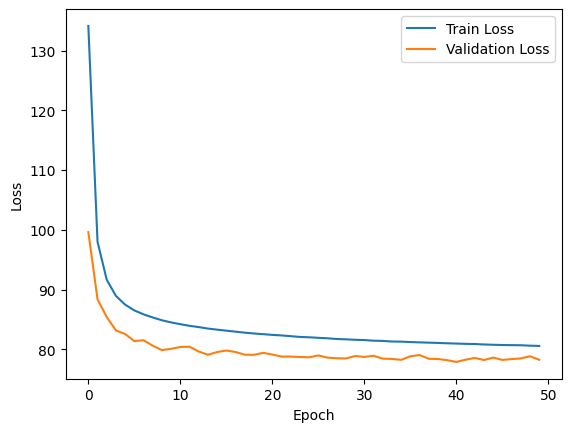

In [ ]:
# Визуализация графиков потерь
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 100) for _ in range(10)])
z = torch.tensor(z, dtype=torch.float32).to(device)

# Подаем латентные векторы на декодер и получаем выходные изображения
autoencoder.eval()
with torch.no_grad():
    generated_images = autoencoder.decode(z)

# Выводим полученные изображения
generated_images = generated_images.view(-1, 1, 28, 28)
save_image(generated_images.cpu(), 'generated_images.png', nrow=5, padding=2)

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

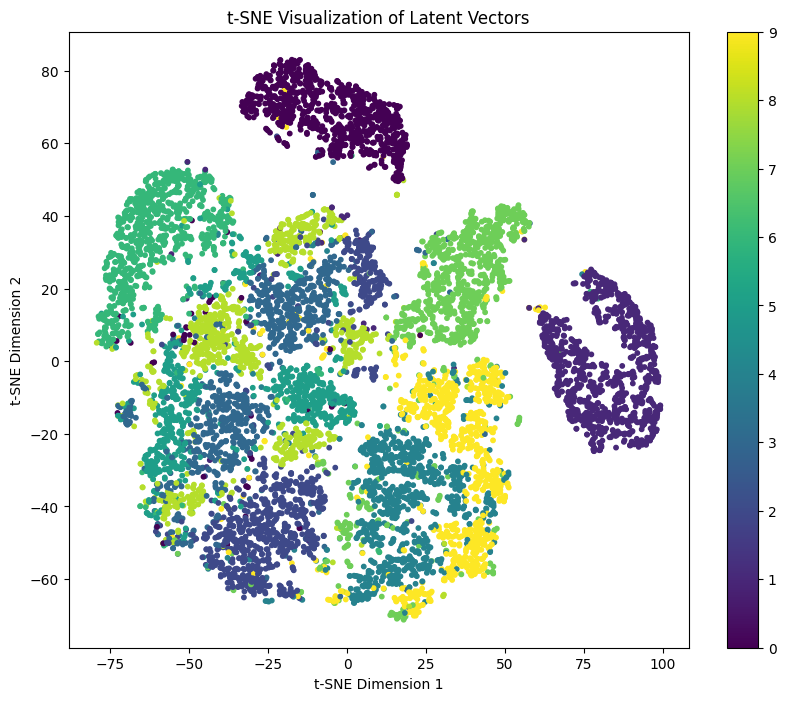

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Включим режим оценки (evaluation) для декодера
autoencoder.eval()

# Получим латентные представления и метки классов тестового датасета
latent_vectors = []
labels = []
with torch.no_grad():
    for batch, batch_labels in test_loader:
        _, mu, _ = autoencoder(batch.to(device))
        latent_vectors.append(mu)
        labels.append(batch_labels)
latent_vectors = torch.cat(latent_vectors).cpu().numpy()
labels = torch.cat(labels).cpu().numpy()

# Применим t-SNE для снижения размерности до 2
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(latent_vectors)

# Визуализация с помощью scatter
plt.figure(figsize=(10, 8))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='viridis', s=10)
plt.colorbar()
plt.title('t-SNE Visualization of Latent Vectors')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [15]:
class CVAE(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(CVAE, self).__init__()
        self.latent_dim  = latent_dim
        self.num_classes = num_classes

        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.encoder_fc = nn.Sequential(
            nn.Linear(64 * 7 * 7 + num_classes, 512),
            nn.ReLU(),
        )

        self.mu_layer = nn.Linear(512, latent_dim)
        self.logsigma_layer = nn.Linear(512, latent_dim)

        # Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 512),
            nn.ReLU(),
            nn.Linear(512, 64 * 7 * 7),
            nn.ReLU(),
        )

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x, class_num):
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)

        class_info = torch.zeros((x.size(0), self.num_classes), device=x.device)
        class_info[:, class_num] = 1  # One-hot encoding of the class

        x = torch.cat((x, class_info), dim=1)
        x = self.encoder_fc(x)

        mu = self.mu_layer(x)
        logsigma = self.logsigma_layer(x)

        return mu, logsigma, class_info

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = logsigma.exp()
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z, class_info):
        z = torch.cat((z, class_info), dim=1)
        x = self.decoder_fc(z)
        x = x.view(-1, 64, 7, 7)
        reconstruction = self.decoder_conv(x)

        return reconstruction

    def forward(self, x, class_num):
        mu, logsigma, class_info = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_info)
        return mu, logsigma, reconstruction



In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae

latent_dim = 20
num_classes = 10
autoencoder = CVAE(latent_dim, num_classes).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

Epoch [1/20] - Train Loss: 124.4542, Val Loss: 92.9926
Epoch [2/20] - Train Loss: 93.9753, Val Loss: 86.9623
Epoch [3/20] - Train Loss: 90.1285, Val Loss: 84.5525
Epoch [4/20] - Train Loss: 88.4381, Val Loss: 83.8242
Epoch [5/20] - Train Loss: 87.4012, Val Loss: 83.3909
Epoch [6/20] - Train Loss: 86.6749, Val Loss: 83.7303
Epoch [7/20] - Train Loss: 86.0952, Val Loss: 82.5816
Epoch [8/20] - Train Loss: 85.5699, Val Loss: 81.9832
Epoch [9/20] - Train Loss: 85.1468, Val Loss: 81.1784
Epoch [10/20] - Train Loss: 84.8310, Val Loss: 82.2042
Epoch [11/20] - Train Loss: 84.4824, Val Loss: 81.2479
Epoch [12/20] - Train Loss: 84.2249, Val Loss: 80.5128
Epoch [13/20] - Train Loss: 83.9685, Val Loss: 81.2578
Epoch [14/20] - Train Loss: 83.7687, Val Loss: 80.7415
Epoch [15/20] - Train Loss: 83.5576, Val Loss: 80.5853
Epoch [16/20] - Train Loss: 83.3493, Val Loss: 80.6638
Epoch [17/20] - Train Loss: 83.1480, Val Loss: 80.7834
Epoch [18/20] - Train Loss: 83.0089, Val Loss: 80.4530
Epoch [19/20] - Tr

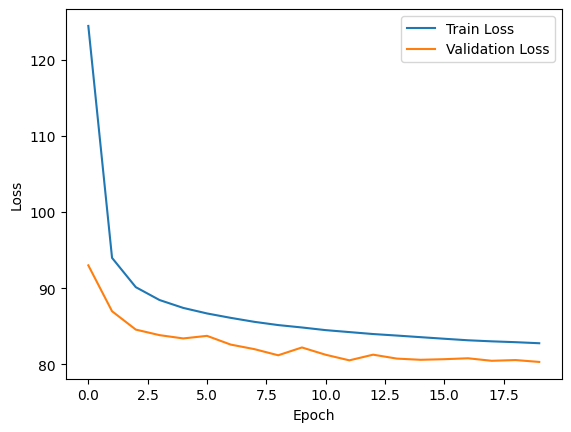

In [17]:
from torchvision.utils import save_image
n_epochs = 20

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    autoencoder.train()
    train_loss = 0.0
    for batch, labels in train_loader:
        batch = batch.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        mu, logsigma, reconstruction = autoencoder(batch, labels)
        loss = loss_vae(batch, mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch, labels in test_loader:
            batch  = batch.to(device)
            labels = labels.to(device)

            mu, logsigma, reconstruction = autoencoder(batch, labels)
            loss = loss_vae(batch, mu, logsigma, reconstruction)
            val_loss += loss.item()

    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{n_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


# Визуализация графиков потерь
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

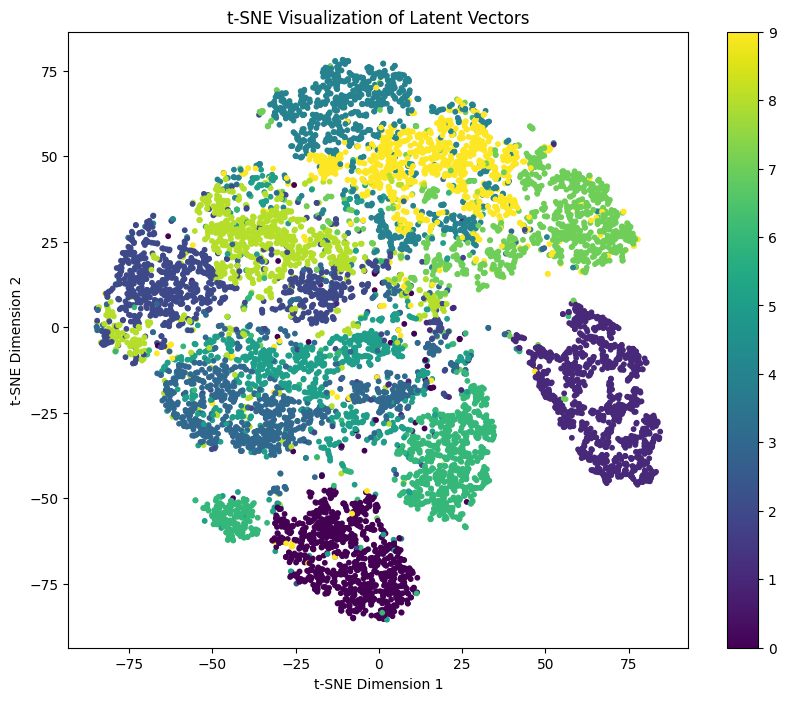

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Включим режим оценки (evaluation) для декодера
autoencoder.eval()

# Получим латентные представления и метки классов тестового датасета
latent_vectors = []
labels = []
with torch.no_grad():
    for batch, batch_labels in test_loader:
        _, mu, _ = autoencoder(batch.to(device), batch_labels.to(device))
        latent_vectors.append(mu)
        labels.append(batch_labels)
latent_vectors = torch.cat(latent_vectors).cpu().numpy()
labels = torch.cat(labels).cpu().numpy()

# Применим t-SNE для снижения размерности до 2
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(latent_vectors)

# Визуализация с помощью scatter
plt.figure(figsize=(10, 8))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='viridis', s=10)
plt.colorbar()
plt.title('t-SNE Visualization of Latent Vectors')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

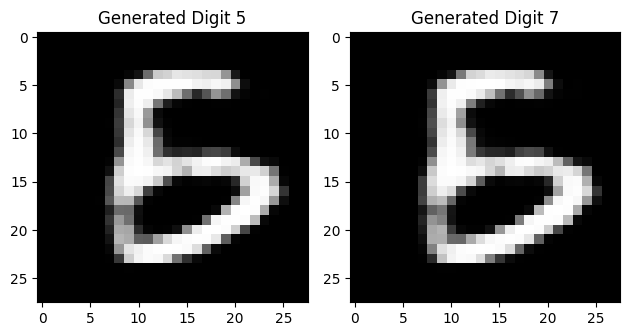

In [57]:
latent_vector = torch.randn(1, 20).to(device)

# Генерируем изображение для класса 5
class_5 = 5
class_vector_5 = torch.zeros(1, 10, device=device)
class_vector_5[0, class_5] = 1
with torch.no_grad():
    generated_image_5 = autoencoder.decode(latent_vector, class_vector_5)

# Генерируем изображение для класса 7
class_7 = 7
class_vector_7 = torch.zeros(1, 10, device=device)
class_vector_7[0, class_7] = 1
with torch.no_grad():
    generated_image_7 = autoencoder.decode(latent_vector, class_vector_7)

# Отображение сгенерированных изображений
plt.subplot(1, 2, 1)
plt.imshow(generated_image_5.squeeze().cpu(), cmap='gray')
plt.title('Generated Digit 5')

plt.subplot(1, 2, 2)
plt.imshow(generated_image_7.squeeze().cpu(), cmap='gray')
plt.title('Generated Digit 7')

plt.tight_layout()
plt.show()

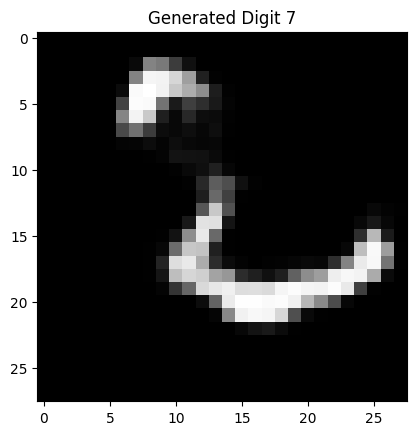

In [50]:
# Генерируем изображения для классов 5 и 7 с использованием одного латентного вектора
with torch.no_grad():
    generated_image_7 = autoencoder.decode(latent_vector, torch.tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]], device=device, dtype=torch.float32))

plt.imshow(generated_image_7.squeeze().cpu(), cmap='gray')
plt.title('Generated Digit 7')
plt.show()

Splendid! Вы великолепны!


In [58]:
import torch
import numpy as np
import torch.nn as nn
from collections import OrderedDict
import os, time, tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class MLP(nn.Module):
    def __init__(self, hidden_size, last_activation = True):
        super(MLP, self).__init__()
        q = []
        for i in range(len(hidden_size)-1):
            in_dim = hidden_size[i]
            out_dim = hidden_size[i+1]
            q.append(("Linear_%d" % i, nn.Linear(in_dim, out_dim)))
            if (i < len(hidden_size)-2) or ((i == len(hidden_size) - 2) and (last_activation)):
                q.append(("BatchNorm_%d" % i, nn.BatchNorm1d(out_dim)))
                q.append(("ReLU_%d" % i, nn.ReLU(inplace=True)))
        self.mlp = nn.Sequential(OrderedDict(q))
    def forward(self, x):
        return self.mlp(x)

class Encoder(nn.Module):
    def __init__(self, shape, nhid = 16, ncond = 0):
        super(Encoder, self).__init__()
        c, h, w = shape
        ww = ((w-8)//2 - 4)//2
        hh = ((h-8)//2 - 4)//2
        self.encode = nn.Sequential(nn.Conv2d(c, 16, 5, padding = 0), nn.BatchNorm2d(16), nn.ReLU(inplace = True),
                                    nn.Conv2d(16, 32, 5, padding = 0), nn.BatchNorm2d(32), nn.ReLU(inplace = True),
                                    nn.MaxPool2d(2, 2),
                                    nn.Conv2d(32, 64, 3, padding = 0), nn.BatchNorm2d(64), nn.ReLU(inplace = True),
                                    nn.Conv2d(64, 64, 3, padding = 0), nn.BatchNorm2d(64), nn.ReLU(inplace = True),
                                    nn.MaxPool2d(2, 2),
                                    Flatten(), MLP([ww*hh*64, 256, 128])
                                   )
        self.calc_mean = MLP([128+ncond, 64, nhid], last_activation = False)
        self.calc_logvar = MLP([128+ncond, 64, nhid], last_activation = False)
    def forward(self, x, y = None):
        x = self.encode(x)
        if (y is None):
            return self.calc_mean(x), self.calc_logvar(x)
        else:
            return self.calc_mean(torch.cat((x, y), dim=1)), self.calc_logvar(torch.cat((x, y), dim=1))

class Decoder(nn.Module):
    def __init__(self, shape, nhid = 16, ncond = 0):
        super(Decoder, self).__init__()
        c, w, h = shape
        self.shape = shape
        self.decode = nn.Sequential(MLP([nhid+ncond, 64, 128, 256, c*w*h], last_activation = False), nn.Sigmoid())
    def forward(self, z, y = None):
        c, w, h = self.shape
        if (y is None):
            return self.decode(z).view(-1, c, w, h)
        else:
            return self.decode(torch.cat((z, y), dim=1)).view(-1, c, w, h)


class cVAE(nn.Module):
    def __init__(self, shape, nclass, nhid = 16, ncond = 16):
        super(cVAE, self).__init__()
        self.dim = nhid
        self.encoder = Encoder(shape, nhid, ncond = ncond)
        self.decoder = Decoder(shape, nhid, ncond = ncond)
        self.label_embedding = nn.Embedding(nclass, ncond)

    def sampling(self, mean, logvar):
        eps = torch.randn(mean.shape).to(device)
        sigma = 0.5 * torch.exp(logvar)
        return mean + eps * sigma

    def forward(self, x, y):
        y = self.label_embedding(y)
        mean, logvar = self.encoder(x, y)
        z = self.sampling(mean, logvar)
        return self.decoder(z, y), mean, logvar

    def generate(self, class_idx):
        if (type(class_idx) is int):
            class_idx = torch.tensor(class_idx)
        class_idx = class_idx.to(device)
        if (len(class_idx.shape) == 0):
            batch_size = None
            class_idx = class_idx.unsqueeze(0)
            z = torch.randn((1, self.dim)).to(device)
        else:
            batch_size = class_idx.shape[0]
            z = torch.randn((batch_size, self.dim)).to(device)
        y = self.label_embedding(class_idx)
        res = self.decoder(z, y)
        if not batch_size:
            res = res.squeeze(0)
        return res

BCE_loss = nn.BCELoss(reduction = "sum")

def loss(X, X_hat, mean, logvar):
    reconstruction_loss = BCE_loss(X_hat, X)
    KL_divergence = 0.5 * torch.sum(-1 - logvar + torch.exp(logvar) + mean**2)
    return reconstruction_loss + KL_divergence

class EarlyStop:
    """Used to early stop the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=20, verbose=False, delta=0,
                 save_name="checkpoint.pt"):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 20
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            save_name (string): The filename with which the model and the optimizer is saved when improved.
                            Default: "checkpoint.pt"
        """
        self.patience = patience
        self.verbose = verbose
        self.save_name = save_name
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, optimizer):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer)
        elif score < self.best_score - self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer)
            self.counter = 0

        return self.early_stop

    def save_checkpoint(self, val_loss, model, optimizer):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        state = {"net":model.state_dict(), "optimizer":optimizer.state_dict()}
        torch.save(state, self.save_name)
        self.val_loss_min = val_loss


net = cVAE((1, 28, 28), 10, nhid = 2, ncond = 16)
net.to(device)
print(net)
save_name = "cVAE.pt"

############### training #########################

lr = 0.01
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr, weight_decay = 0.0001)

def adjust_lr(optimizer, decay_rate=0.95):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay_rate

retrain = True
if os.path.exists(save_name):
    print("Model parameters have already been trained before. Retrain ? (y/n)")
    ans = input()
    if not (ans == 'y'):
        checkpoint = torch.load(save_name, map_location = device)
        net.load_state_dict(checkpoint["net"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        for g in optimizer.param_groups:
            g['lr'] = lr

max_epochs = 20
early_stop = EarlyStop(patience = 20, save_name = save_name)
net = net.to(device)

print("training on ", device)
for epoch in range(max_epochs):

    train_loss, n, start = 0.0, 0, time.time()
    for X, y in tqdm.tqdm(train_loader, ncols = 50):
        X = X.to(device)
        y = y.to(device)
        X_hat, mean, logvar = net(X, y)

        l = loss(X, X_hat, mean, logvar).to(device)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        train_loss += l.cpu().item()
        n += X.shape[0]

    train_loss /= n
    print('epoch %d, train loss %.4f , time %.1f sec'
          % (epoch, train_loss, time.time() - start))

    adjust_lr(optimizer)

    if (early_stop(train_loss, net, optimizer)):
        break

checkpoint = torch.load(early_stop.save_name)
net.load_state_dict(checkpoint["net"])

cVAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (14): Flatten()
      (15): MLP(
    

100%|█████████| 1875/1875 [00:21<00:00, 87.61it/s]


epoch 0, train loss 148.1084 , time 21.4 sec


100%|█████████| 1875/1875 [00:21<00:00, 86.28it/s]


epoch 1, train loss 139.3875 , time 21.7 sec


100%|█████████| 1875/1875 [00:21<00:00, 86.03it/s]


epoch 2, train loss 137.4266 , time 21.8 sec


100%|█████████| 1875/1875 [00:21<00:00, 87.64it/s]


epoch 3, train loss 136.0887 , time 21.4 sec


100%|█████████| 1875/1875 [00:20<00:00, 91.53it/s]


epoch 4, train loss 135.1466 , time 20.5 sec


100%|█████████| 1875/1875 [00:21<00:00, 86.58it/s]


epoch 5, train loss 134.4786 , time 21.7 sec


100%|█████████| 1875/1875 [00:21<00:00, 86.25it/s]


epoch 6, train loss 133.8070 , time 21.7 sec


100%|█████████| 1875/1875 [00:21<00:00, 86.71it/s]


epoch 7, train loss 133.2678 , time 21.6 sec


100%|█████████| 1875/1875 [00:20<00:00, 90.86it/s]


epoch 8, train loss 132.6928 , time 20.6 sec


100%|█████████| 1875/1875 [00:21<00:00, 86.51it/s]


epoch 9, train loss 132.2399 , time 21.7 sec


100%|█████████| 1875/1875 [00:21<00:00, 87.06it/s]


epoch 10, train loss 131.8906 , time 21.5 sec


100%|█████████| 1875/1875 [00:21<00:00, 87.30it/s]


epoch 11, train loss 131.5242 , time 21.5 sec


100%|█████████| 1875/1875 [00:20<00:00, 89.77it/s]


epoch 12, train loss 131.1134 , time 20.9 sec


100%|█████████| 1875/1875 [00:21<00:00, 85.62it/s]


epoch 13, train loss 130.8500 , time 21.9 sec


100%|█████████| 1875/1875 [00:22<00:00, 85.21it/s]


epoch 14, train loss 130.4164 , time 22.0 sec


100%|█████████| 1875/1875 [00:22<00:00, 84.85it/s]


epoch 15, train loss 130.2028 , time 22.1 sec


100%|█████████| 1875/1875 [00:22<00:00, 83.62it/s]


epoch 16, train loss 130.0112 , time 22.4 sec


100%|█████████| 1875/1875 [00:21<00:00, 89.22it/s]


epoch 17, train loss 129.8530 , time 21.0 sec


100%|█████████| 1875/1875 [00:21<00:00, 86.18it/s]


epoch 18, train loss 129.6359 , time 21.8 sec


100%|█████████| 1875/1875 [00:21<00:00, 86.55it/s]


epoch 19, train loss 129.3898 , time 21.7 sec


<All keys matched successfully>

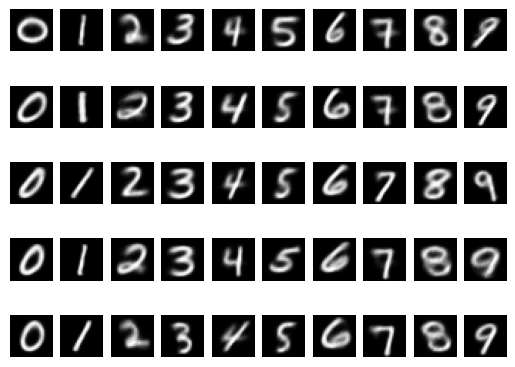

In [61]:
from matplotlib import cm

with torch.no_grad():
    x = net.generate(torch.tensor([list(range(10))] * 5).clone().view(-1))

for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.axis("off")
    plt.imshow(x[i].squeeze(0).cpu().numpy(), cm.gray)

### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
<ваш код получения латентных представлений, применения TSNE и визуализации>

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>